# PARTIE 1 : Préparation du Dataset (à ne lancer qu'une fois)
Génération du dataset, feature selection + preparation of the data.

> **⚠️ Cette partie télécharge et transforme les données brutes.** Une fois le CSV final sauvegardé, vous pouvez passer directement à la **PARTIE 2** pour le Machine Learning.

### A ne pas relancer !!

On regarde maintenant la colonne amneties (tres important donne tout les détails sur les appartements)

Probleme cette version du fichier n'a pas amneties qui serait une varible important pour la prédiction du prix

In [1]:
import pandas as pd
import requests
import os

# C'est LA version gagnante d'après votre audit
WINNING_DATE = "2024-06-10"
DATA_URL = f"http://data.insideairbnb.com/france/ile-de-france/paris/{WINNING_DATE}/data/listings.csv.gz"
SAVE_PATH = "data/paris_listings_final.csv.gz"

print(f"--- TÉLÉCHARGEMENT DE LA VERSION GAGNANTE ({WINNING_DATE}) ---")

# 1. TÉLÉCHARGEMENT
if not os.path.exists(SAVE_PATH):
    print(f"Téléchargement depuis : {DATA_URL}")
    try:
        response = requests.get(DATA_URL, stream=True)
        if response.status_code == 200:
            with open(SAVE_PATH, 'wb') as f:
                for chunk in response.iter_content(chunk_size=1024*1024):
                    f.write(chunk)
            print("✅ Téléchargement terminé !")
        else:
            print("❌ Erreur de téléchargement (404 ou autre).")
    except Exception as e:
        print(f"❌ Erreur technique : {e}")
else:
    print("ℹ️ Le fichier existe déjà.")

# 2. CHARGEMENT ET NETTOYAGE PRÉLIMINAIRE
print("\n--- PRÉPARATION DU DATASET ---")
# On charge
df = pd.read_csv(SAVE_PATH, compression='gzip')
print(f"Taille brute : {len(df)} lignes")

# On nettoie le prix
# Conversion string -> float
df['price_clean'] = df['price'].astype(str).str.replace(r'[$,]', '', regex=True)
df['price_clean'] = pd.to_numeric(df['price_clean'], errors='coerce')

# On supprime les lignes sans prix (les fameux 18.4%)
df_clean = df.dropna(subset=['price_clean'])

print(f"Taille après suppression des sans-prix : {len(df_clean)} lignes")
print(f"Perte de données : {100 - (len(df_clean)/len(df)*100):.1f}% (Acceptable)")

# 3. VÉRIFICATION AMENITIES
sample_amenity = str(df_clean['amenities'].iloc[0])
print(f"\nExemple d'amenities : {sample_amenity[:50]}...")

if "wifi" in sample_amenity.lower() or "[" in sample_amenity:
    print("✅ AMENITIES CONFIRMÉES : Prêt pour le Feature Engineering !")
    
    # On sauvegarde cette version propre pour ne plus avoir à retélécharger
    df_clean.to_csv("data/paris_listings_ready.csv", index=False)
    print("💾 Fichier de travail sauvegardé sous : 'data/paris_listings_ready.csv'")
else:
    print("⚠️ ATTENTION : Les amenities semblent vides.")

--- TÉLÉCHARGEMENT DE LA VERSION GAGNANTE (2024-06-10) ---
ℹ️ Le fichier existe déjà.

--- PRÉPARATION DU DATASET ---
Taille brute : 95885 lignes
Taille après suppression des sans-prix : 74579 lignes
Perte de données : 22.2% (Acceptable)

Exemple d'amenities : ["Smart lock", "Smoke alarm", "Cooking basics", "H...
✅ AMENITIES CONFIRMÉES : Prêt pour le Feature Engineering !
💾 Fichier de travail sauvegardé sous : 'data/paris_listings_ready.csv'



2. Chargement du fichier : data/paris_listings_ready.csv...
   -> 34 colonnes supprimées (Liées au Host ou Scrapping).
   -> Reste : 42 colonnes axées sur le LOGEMENT.

3. Génération de l'audit de complétude...


C:\Users\User\AppData\Local\Temp\ipykernel_15096\882945087.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Taux_Presence', y='Variable', data=presence_df, palette=colors)


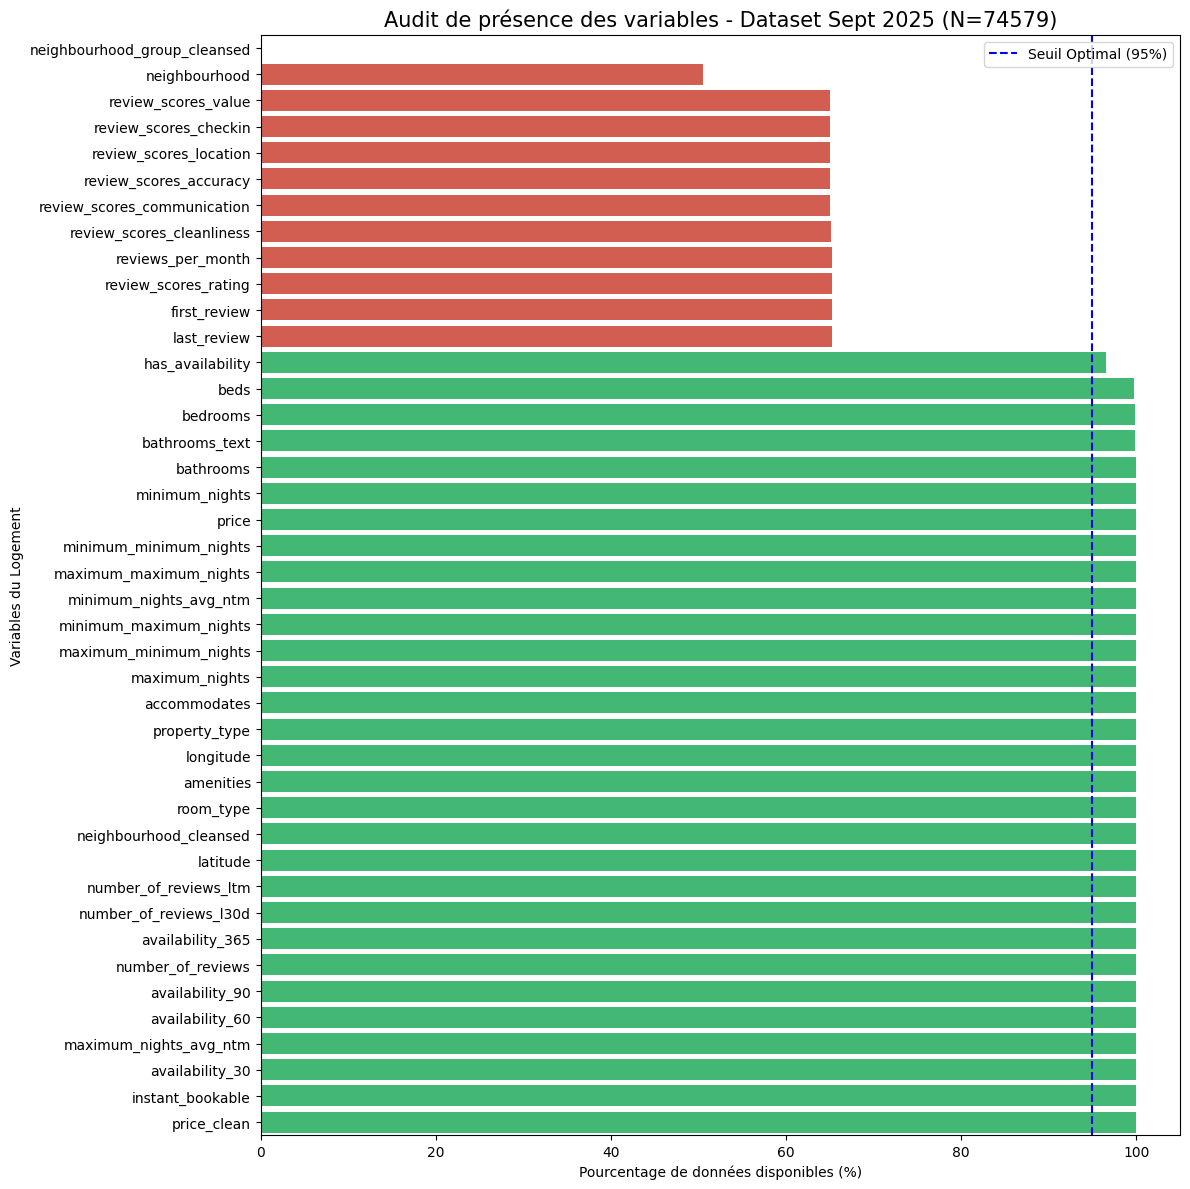


--- ⚠️ VARIABLES VIDES (0% de données) ---
['neighbourhood_group_cleansed']

--- CHECK CRITIQUE : AMENITIES ---
✅ AMENITIES : 100.00% (C'est bon !)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
# On pointe bien sur le NOUVEAU fichier téléchargé (Sept 2025)
RAW_FILE_PATH = "data/paris_listings_ready.csv"

if not os.path.exists(RAW_FILE_PATH):
    print(f"⚠️ ERREUR : Le fichier {RAW_FILE_PATH} est introuvable.")
    print("Assurez-vous d'avoir lancé le script de téléchargement précédent.")
else:
    # ==============================================================================
    # 2. CHARGEMENT & FILTRAGE (Scraping & Host)
    # ==============================================================================
    print(f"\n2. Chargement du fichier : {RAW_FILE_PATH}...")
    df = pd.read_csv(RAW_FILE_PATH)

    # Définition des colonnes techniques à supprimer (Scraping)
    scraping_cols = [
        'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 
        'description', 'neighborhood_overview', 'picture_url', 'calendar_updated', 
        'calendar_last_scraped', 'license'
    ]

    # Identification automatique des colonnes "Host" (Hôte)
    host_cols = [c for c in df.columns if c.startswith('host_') or c.startswith('calculated_host_')]

    # Liste totale à supprimer
    cols_to_drop = scraping_cols + host_cols

    # On ne supprime que celles qui existent vraiment dans le fichier
    existing_drops = [c for c in cols_to_drop if c in df.columns]
    df_audit = df.drop(columns=existing_drops)

    print(f"   -> {len(existing_drops)} colonnes supprimées (Liées au Host ou Scrapping).")
    print(f"   -> Reste : {df_audit.shape[1]} colonnes axées sur le LOGEMENT.")

    # ==============================================================================
    # 3. AUDIT VISUEL (Barplot)
    # ==============================================================================
    print("\n3. Génération de l'audit de complétude...")

    # Calcul du % de présence
    presence = df_audit.notnull().mean() * 100
    presence_df = presence.reset_index()
    presence_df.columns = ['Variable', 'Taux_Presence']
    presence_df = presence_df.sort_values(by='Taux_Presence', ascending=True)

    # Visualisation
    plt.figure(figsize=(12, 12))
    # Code couleur : Rouge si < 90%, Vert sinon
    colors = ['#e74c3c' if x < 90 else '#2ecc71' for x in presence_df['Taux_Presence']]

    sns.barplot(x='Taux_Presence', y='Variable', data=presence_df, palette=colors)

    plt.axvline(x=95, color='blue', linestyle='--', label='Seuil Optimal (95%)')
    plt.title(f'Audit de présence des variables - Dataset Sept 2025 (N={len(df)})', fontsize=15)
    plt.xlabel('Pourcentage de données disponibles (%)')
    plt.ylabel('Variables du Logement')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Affichage des variables vides à 100% (à supprimer immédiatement)
    print("\n--- ⚠️ VARIABLES VIDES (0% de données) ---")
    empty_cols = presence_df[presence_df['Taux_Presence'] == 0]['Variable'].tolist()
    print(empty_cols if empty_cols else "Aucune variable totalement vide.")
    
    # CHECK SPECIFIQUE AMENITIES
    print("\n--- CHECK CRITIQUE : AMENITIES ---")
    amenities_score = presence_df[presence_df['Variable'] == 'amenities']['Taux_Presence'].values
    if len(amenities_score) > 0 and amenities_score[0] > 99:
         print(f"✅ AMENITIES : {amenities_score[0]:.2f}% (C'est bon !)")
    else:
         print(f"❌ AMENITIES : {amenities_score}% (Problème persistant)")

Vérification de la variable prix et amneties parce que j'ai trop souffert

=== 1. VÉRIFICATION CIBLÉE (PRIX & AMENITIES) ===

--- Distribution du Prix (74579 lignes) ---
count    74579.000000
mean       289.075155
std        684.010923
min         10.000000
25%        109.000000
50%        164.000000
75%        290.000000
max      72000.000000
Name: price_clean, dtype: float64


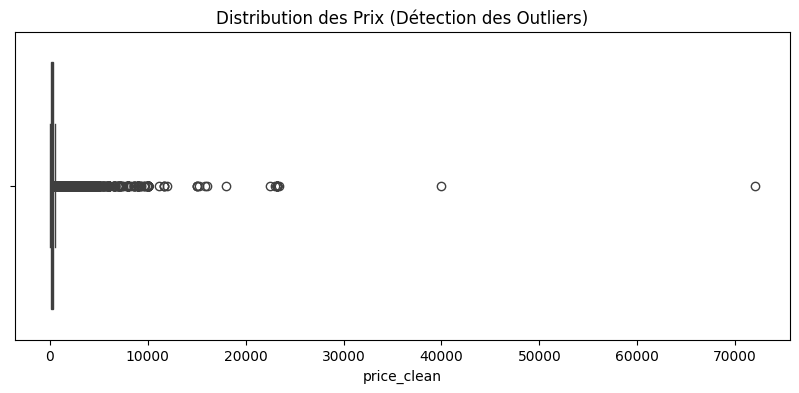


--- Structure des Amenities (Exemple Ligne 0) ---
Type : <class 'str'>
Contenu : ["Smart lock", "Smoke alarm", "Cooking basics", "Hangers", "Wifi", "Dishes and silverware", "Hair dryer", "Children\u2019s books and toys", "Kitchen",...
Parsing Test : OK (15 équipements détectés)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement du fichier propre sauvegardé précédemment
# (Assurez-vous que c'est bien le fichier csv non-compressé ou le .gz nettoyé)
INPUT_FILE = "data/paris_listings_ready.csv" 
df = pd.read_csv(INPUT_FILE)

print("=== 1. VÉRIFICATION CIBLÉE (PRIX & AMENITIES) ===")

# A. Analyse du PRIX
print(f"\n--- Distribution du Prix ({len(df)} lignes) ---")
print(df['price_clean'].describe())

# Visualisation rapide des prix pour voir les outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['price_clean'])
plt.title("Distribution des Prix (Détection des Outliers)")
plt.show()

# B. Analyse des AMENITIES
print("\n--- Structure des Amenities (Exemple Ligne 0) ---")
amenity_sample = df['amenities'].iloc[0]
print(f"Type : {type(amenity_sample)}")
print(f"Contenu : {str(amenity_sample)[:150]}...") # On affiche les 150 premiers caractères

# Test de parsing
import json
try:
    # On teste si c'est du JSON standard
    test_parse = json.loads(amenity_sample.replace("'", '"')) if isinstance(amenity_sample, str) else amenity_sample
    print(f"Parsing Test : OK ({len(test_parse)} équipements détectés)")
except:
    print("Parsing Test : Format complexe (nécessitera un nettoyage spécifique)")

In [4]:
import pandas as pd

# (Assure-toi que 'df' est chargé avec le fichier 'paris_listings_ready.csv')
# df = pd.read_csv("data/paris_listings_ready.csv")

print("\n=== 2. SUPPRESSION MASSIVE (Rouges + Scraping + Host) ===")

# A. Indicateurs Rouges / Manquants (Ta liste)
red_flags = [
    'neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated', 'license',
    'neighbourhood', 'neighborhood_overview', 'first_review', 'last_review',
    'reviews_per_month', 'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin', 
    'review_scores_communication', 'review_scores_location', 'review_scores_value'
]

# B. Métadonnées de Scraping (Inutile pour le modèle)
scraping_metadata = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 
    'picture_url', 'calendar_last_scraped', 'name', 'description' 
    # 'name' et 'description' sont du texte libre non structuré, on utilise amenities à la place
]

# C. Données de l'Hôte (On juge le bien, pas la personne)
host_info = [
    'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 
    'host_about', 'host_response_time', 'host_response_rate', 
    'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 
    'host_picture_url', 'host_neighbourhood', 'host_listings_count', 
    'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 
    'host_identity_verified', 'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes', 
    'calculated_host_listings_count_private_rooms', 
    'calculated_host_listings_count_shared_rooms'
]

# D. Redondances (On a déjà price_clean)
redundant = ['price', 'has_availability'] 

# Fusion des listes
cols_to_drop = red_flags + scraping_metadata + host_info + redundant

# Suppression sécurisée
existing_drops = [c for c in cols_to_drop if c in df.columns]
df_lean = df.drop(columns=existing_drops)

print(f"Colonnes supprimées : {len(existing_drops)}")
print(f"Colonnes restantes : {len(df_lean.columns)}")

print("\n=== 3. AUDIT FINAL & DISTRIBUTION DES SURVIVANTS ===")

# On sépare les numériques des objets pour une analyse adaptée
num_cols = df_lean.select_dtypes(include=['number']).columns
obj_cols = df_lean.select_dtypes(include=['object']).columns

print(f"\n--- A. Variables Numériques ({len(num_cols)}) ---")
# On affiche un résumé statistique complet
print(df_lean[num_cols].describe().T[['count', 'mean', 'min', '50%', 'max']])

print(f"\n--- B. Variables Catégorielles / Texte ({len(obj_cols)}) ---")
for col in obj_cols:
    unique_count = df_lean[col].nunique()
    print(f"\n> Colonne : {col} (uniques: {unique_count})")
    if unique_count < 15:
        # Si peu de catégories, on affiche la distribution
        print(df_lean[col].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
    else:
        # Sinon on montre juste un exemple
        print(f"  Exemple : {df_lean[col].iloc[0][:50]}...")



=== 2. SUPPRESSION MASSIVE (Rouges + Scraping + Host) ===
Colonnes supprimées : 49
Colonnes restantes : 27

=== 3. AUDIT FINAL & DISTRIBUTION DES SURVIVANTS ===

--- A. Variables Numériques (21) ---
                          count           mean        min         50%  \
latitude                74579.0      48.863959  48.816080   48.865132   
longitude               74579.0       2.341852   2.227178    2.345910   
accommodates            74579.0       3.381555   1.000000    3.000000   
bedrooms                74457.0       1.340075   0.000000    1.000000   
beds                    74427.0       1.573381   0.000000    1.000000   
minimum_nights          74579.0       9.976039   1.000000    3.000000   
maximum_nights          74579.0   29205.314177   1.000000  365.000000   
minimum_minimum_nights  74579.0       8.603829   1.000000    2.000000   
maximum_minimum_nights  74579.0      14.174727   1.000000    3.000000   
minimum_maximum_nights  74579.0   29218.217434   1.000000  365.000000 

C:\Users\User\AppData\Local\Temp\ipykernel_15096\3103840427.py:54: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  obj_cols = df_lean.select_dtypes(include=['object']).columns



> Colonne : amenities (uniques: 65363)
  Exemple : ["Smart lock", "Smoke alarm", "Cooking basics", "H...

> Colonne : instant_bookable (uniques: 2)
instant_bookable
f    75.3%
t    24.7%
Name: proportion, dtype: str


encodage amneties et tt

=== TOP 50 DES AMENITIES LES PLUS FRÉQUENTES ===
                            count
Kitchen                     69676
Wifi                        66596
Smoke alarm                 57304
Hot water                   56073
Essentials                  53450
Hair dryer                  52177
Dishes and silverware       51611
Bed linens                  50821
Cooking basics              50625
Iron                        48111
Refrigerator                47818
Hangers                     46897
Washer                      46746
Microwave                   41038
TV                          40045
Heating                     38180
Hot water kettle            37225
Shampoo                     35881
Dedicated workspace         35842
Cleaning products           34886
Wine glasses                32275
Baking sheet                31096
Freezer                     30680
Toaster                     30522
Oven                        30233
Dining table                30083
Dishwasher                  29822

<Axes: title={'center': 'Top 30 Amenities à Paris'}>

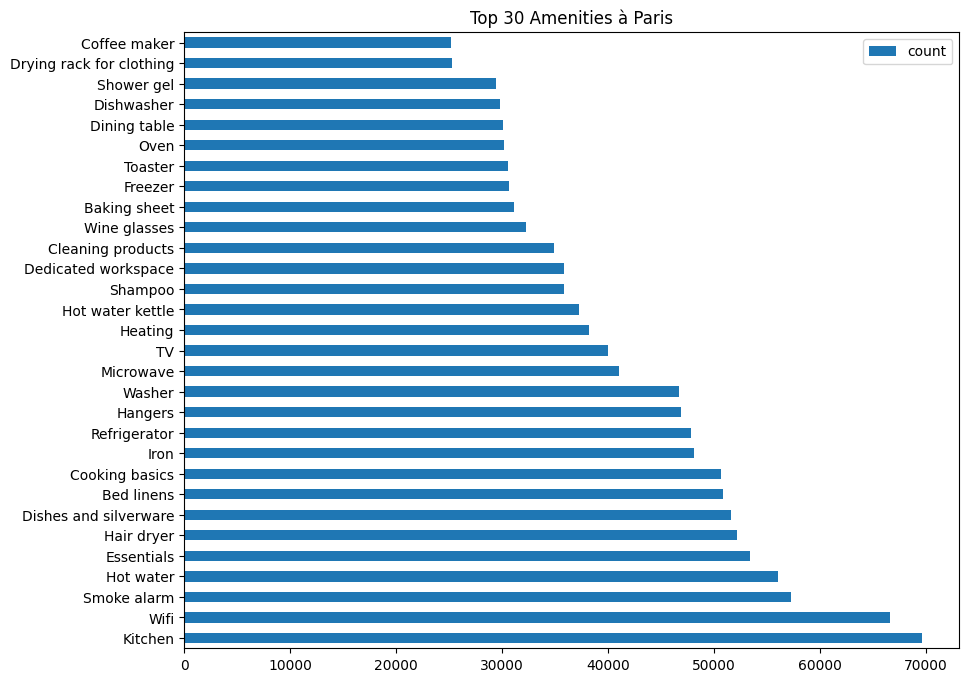

In [5]:
from collections import Counter
import json

# 1. On transforme les strings en listes réelles
def get_amenities_list(x):
    try:
        # Gère le format JSON ["Wifi", "TV"] ou le format simple
        return json.loads(x.replace("'", '"')) if isinstance(x, str) else x
    except:
        return []

all_amenities = []
df_lean['amenities'].apply(get_amenities_list).apply(all_amenities.extend)

# 2. On compte les occurrences
amenity_counts = Counter(all_amenities)
amenity_freq = pd.DataFrame.from_dict(amenity_counts, orient='index', columns=['count'])
amenity_freq = amenity_freq.sort_values(by='count', ascending=False)

# 3. Affichage du Top 50 pour faire votre choix
print("=== TOP 50 DES AMENITIES LES PLUS FRÉQUENTES ===")
print(amenity_freq.head(50))

# Visualisation de la "longue traîne"
amenity_freq.head(30).plot(kind='barh', figsize=(10, 8), title="Top 30 Amenities à Paris")

On va maintenant creer des categories avec des score pour le umap sinon il kiffe pas ca nique la distance euclidienne

In [6]:
import pandas as pd
import numpy as np

df_final = df_lean.copy()
df_final['amen_raw'] = df_final['amenities'].astype(str).str.lower()

# --- A. LES POWER ITEMS (One-Hot / Binaire) ---
# Ces items sont si impactants qu'ils méritent leur propre colonne
power_items = {
    'has_ac': 'air conditioning',
    'has_elevator': 'elevator',
    'has_parking': 'parking',
    'has_dishwasher': 'dishwasher',
    'has_washing_machine': 'washer'
}

for col, key in power_items.items():
    df_final[col] = df_final['amen_raw'].apply(lambda x: 1 if key in x else 0)

# --- B. LES SCORES THÉMATIQUES GRANULAIRES ---
# On augmente la précision : chaque item trouvé ajoute +1 au score du thème
themes = {
    'score_chef_kitchen': ['oven', 'stove', 'refrigerator', 'freezer', 'baking sheet', 'wine glasses', 'dining table'],
    'score_coffee_station': ['coffee maker', 'hot water kettle', 'coffee', 'toaster'],
    'score_wellness_luxe': ['pool', 'sauna', 'jacuzzi', 'hot tub', 'bathtub', 'shower gel', 'shampoo', 'body soap'],
    'score_comfort_sleep': ['bed linens', 'extra pillows and blankets', 'room-darkening shades', 'heating', 'central heating'],
    'score_work_tech': ['dedicated workspace', 'tv', 'wifi', 'ethernet connection'],
    'score_logistics': ['self check-in', 'lockbox', 'luggage dropoff allowed', 'cleaning products', 'iron', 'hair dryer'],
    'score_safety': ['smoke alarm', 'carbon monoxide alarm', 'first aid kit', 'fire extinguisher']
}

for theme_name, keys in themes.items():
    df_final[theme_name] = df_final['amen_raw'].apply(lambda x: sum(1 for k in keys if k in x))

# --- C. LE SYSTÈME DE STANDING THERMIQUE ---
def get_thermal_standing(x):
    if 'air conditioning' in x: return 2
    if 'portable fans' in x: return 1
    return 0
df_final['standing_thermal'] = df_final['amen_raw'].apply(get_thermal_standing)


In [7]:
# Force l'affichage de toutes les colonnes dans le notebook
pd.set_option('display.max_columns', None)

# Affiche les 5 premières lignes avec toutes les colonnes
print(df_final.head())

  neighbourhood_cleansed  latitude  longitude                property_type  \
0           Observatoire  48.83191    2.31870           Entire rental unit   
1               Panthéon  48.83918    2.34699  Private room in rental unit   
2         Hôtel-de-Ville  48.85247    2.35835           Entire rental unit   
3         Hôtel-de-Ville  48.85909    2.35315           Entire rental unit   
4      Buttes-Montmartre  48.88912    2.36154                 Entire condo   

         room_type  accommodates bathrooms_text  bedrooms  beds  \
0  Entire home/apt             2         1 bath       1.0   0.0   
1     Private room             1      1.5 baths       1.0   1.0   
2  Entire home/apt             2         1 bath       0.0   1.0   
3  Entire home/apt             4         1 bath       2.0   1.0   
4  Entire home/apt             1         1 bath       1.0   1.0   

                                           amenities  minimum_nights  \
0  ["Smart lock", "Smoke alarm", "Cooking basics"...    

In [8]:
# Liste toutes les colonnes créées
print("Liste des colonnes présentes :", df_final.columns.tolist())

# Vérifie que les scores ne sont pas tous à zéro
print("\nDistribution des nouveaux scores :")
score_cols = [c for c in df_final.columns if 'score_' in c or 'has_' in c or 'standing_' in c]
print(df_final[score_cols].describe().loc[['min', 'mean', 'max']])

Liste des colonnes présentes : ['neighbourhood_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'instant_bookable', 'price_clean', 'amen_raw', 'has_ac', 'has_elevator', 'has_parking', 'has_dishwasher', 'has_washing_machine', 'score_chef_kitchen', 'score_coffee_station', 'score_wellness_luxe', 'score_comfort_sleep', 'score_work_tech', 'score_logistics', 'score_safety', 'standing_thermal']

Distribution des nouveaux scores :
        has_ac  has_elevator  has_parking  has_dishwasher  \
min   0.000000      0.000000     0.000000        0.000000   
mean  0.147414      0.3066

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import re

# On travaille sur ton DataFrame actuel
df_ml = df_final.copy()

print("--- DERNIÈRE ÉTAPE D'ENCODAGE ---")

# 1. SALLES DE BAINS : Extraction numérique
def clean_bath(text):
    if pd.isna(text): return 1.0
    text = str(text).lower()
    if 'half' in text: return 0.5
    res = re.findall(r"(\d+(\.\d+)?)", text)
    return float(res[0][0]) if res else 1.0

df_ml['bathrooms_qty'] = df_ml['bathrooms_text'].apply(clean_bath)

# 2. INSTANT BOOKABLE : Mapping binaire
df_ml['instant_bookable_num'] = df_ml['instant_bookable'].map({'t': 1, 'f': 0}).fillna(0)

# 3. TYPE DE PROPRIÉTÉ : Simplification (66 -> 4 catégories)
def group_prop(x):
    x = str(x).lower()
    if 'entire' in x: return 'entire_unit'
    if 'private' in x: return 'private_room'
    if 'hotel' in x or 'boutique' in x: return 'hotel'
    return 'other'

df_ml['prop_group'] = df_ml['property_type'].apply(group_prop)

# 4. ENCODAGE DES QUARTIERS (Target Encoding)
# On remplace le nom du quartier par le prix moyen par nuit de ce quartier
neigh_price_map = df_ml.groupby('neighbourhood_cleansed')['price_clean'].mean()
df_ml['neigh_price_index'] = df_ml['neighbourhood_cleansed'].map(neigh_price_map)

# 5. ONE-HOT ENCODING : Room Type & Property Group
# (On garde le binaire ici car il n'y a que 4 catégories, c'est gérable)
df_ml = pd.get_dummies(df_ml, columns=['room_type', 'prop_group'], prefix=['rt', 'pg'])

# 6. CALCUL DE LA DISTANCE AU CENTRE (Notre-Dame)
# Important pour l'UMAP car la géo brute (lat/lon) est parfois dure à interpréter
# Pas hardocoder le centre de paris, mais pour l'exemple on prend les coordonnées de Notre-Dame
# On va tester plusieurs centres plus tard, mais pour l'instant on garde celui-ci

df_ml['dist_center'] = np.sqrt((df_ml['latitude'] - 48.8530)**2 + (df_ml['longitude'] - 2.3499)**2)

# ==============================================================================
# 7. SÉLECTION FINALE & NORMALISATION (CORRIGÉ)
# ==============================================================================
print("--- NETTOYAGE FINAL ---")

# On sélectionne uniquement les colonnes numériques
# Cela élimine automatiquement : amenities, neighbourhood_cleansed, bathrooms_text, etc.
df_numeric = df_ml.select_dtypes(include=[np.number])

# On vérifie s'il reste des colonnes inutiles (comme l'ID ou la Latitude si on ne les veut pas)
# Sinon, on garde tout ce qui est chiffre.
print(f"Colonnes numériques identifiées : {df_numeric.shape[1]}")

# Remplissage des NaNs restants par la médiane (important pour l'IA)
df_numeric = df_numeric.fillna(df_numeric.median())

# ==============================================================================
# 8. NORMALISATION MIN-MAX
# ==============================================================================
print("--- NORMALISATION ---")
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

print(f"✅ DATASET PRÊT POUR UMAP ! Dimensions : {df_scaled.shape}")
print("Aperçu des colonnes :", df_scaled.columns.tolist()[:10], "... [etc]")

--- DERNIÈRE ÉTAPE D'ENCODAGE ---
--- NETTOYAGE FINAL ---
Colonnes numériques identifiées : 38
--- NORMALISATION ---
✅ DATASET PRÊT POUR UMAP ! Dimensions : (74579, 38)
Aperçu des colonnes : ['latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights'] ... [etc]


df final pour le modele

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. On s'assure que toutes les colonnes créées par One-Hot (True/False) deviennent des 0/1
# Cela règle le problème des colonnes rt_... et pg_...
df_ml_clean = df_ml.copy()
for col in df_ml_clean.columns:
    if df_ml_clean[col].dtype == 'bool':
        df_ml_clean[col] = df_ml_clean[col].astype(int)

# 2. LISTE NOIRE : On définit explicitement les colonnes à supprimer
# On vire tout ce qui est texte ou métadonnée
blacklist = [
    'amenities', 'amen_raw', 'property_type', 'neighbourhood_cleansed', 
    'bathrooms_text', 'instant_bookable', 'id', 'scrape_id', 'host_id'
]

# Suppression sécurisée (seulement si elles existent)
df_ml_clean = df_ml_clean.drop(columns=[c for c in blacklist if c in df_ml_clean.columns])

# 3. FILTRE AUTOMATIQUE : On ne garde QUE le numérique
# Au cas où certaines colonnes de texte auraient survécu
df_final_numeric = df_ml_clean.select_dtypes(include=[np.number])

# 4. TRAITEMENT DES VALEURS MANQUANTES

df_final_numeric = df_final_numeric.fillna(df_final_numeric.median())

# 5. NORMALISATION (Mise à l'échelle 0-1)
# Indispensable pour UMAP afin que le prix n'écrase pas les amenities
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_final_numeric), 
    columns=df_final_numeric.columns,
    index=df_final_numeric.index
)

# --- VÉRIFICATION FINALE ---
print(f"✅ NETTOYAGE TERMINÉ")
print(f"Nombre de colonnes finales : {df_scaled.shape[1]}")
print("-" * 30)
print("Colonnes restantes (Toutes doivent être entre 0 et 1) :")
print(df_scaled.columns.tolist())

# On affiche les 5 premières lignes du vrai dataset ML
df_scaled.head()

✅ NETTOYAGE TERMINÉ
Nombre de colonnes finales : 46
------------------------------
Colonnes restantes (Toutes doivent être entre 0 et 1) :
['latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'price_clean', 'has_ac', 'has_elevator', 'has_parking', 'has_dishwasher', 'has_washing_machine', 'score_chef_kitchen', 'score_coffee_station', 'score_wellness_luxe', 'score_comfort_sleep', 'score_work_tech', 'score_logistics', 'score_safety', 'standing_thermal', 'bathrooms_qty', 'instant_bookable_num', 'neigh_price_index', 'rt_Entire home/apt', 'rt_Hotel room', 'rt_Private room', 'rt_Shared room', 'pg_entire_unit', 'pg_hotel', 'pg_other', 'pg_private_roo

,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,price_clean,has_ac,has_elevator,has_parking,has_dishwasher,has_washing_machine,score_chef_kitchen,score_coffee_station,score_wellness_luxe,score_comfort_sleep,score_work_tech,score_logistics,score_safety,standing_thermal,bathrooms_qty,instant_bookable_num,neigh_price_index,rt_Entire home/apt,rt_Hotel room,rt_Private room,rt_Shared room,pg_entire_unit,pg_hotel,pg_other,pg_private_room,dist_center
0,0.185125,0.379474,0.066667,0.026316,0.000000,0.001001,1.350418e-08,0.001372,0.001001,1.350418e-08,1.350418e-08,0.001304,1.350418e-08,0.966667,0.750000,0.833333,0.956164,0.001304,0.000000,0.000000,0.003334,0.0,0.0,1.0,0.0,1.0,0.000000,0.0,0.000000,0.0,0.25,0.666667,0.25,0.0,0.033333,1.0,0.102145,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.305508
1,0.270144,0.496771,0.000000,0.026316,0.033333,0.029029,8.800998e-08,0.039781,0.029029,8.800998e-08,8.800998e-08,0.037810,8.800998e-08,0.366667,0.200000,0.133333,0.397260,0.013694,0.001229,0.000000,0.000695,0.0,0.0,1.0,1.0,1.0,0.428571,0.5,0.000000,0.6,0.50,0.500000,0.50,0.0,0.050000,0.0,0.265491,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.113733
2,0.425564,0.543872,0.066667,0.000000,0.033333,0.001001,5.234033e-07,0.000000,0.001001,5.234033e-07,5.234033e-07,0.000000,5.234033e-07,0.433333,0.600000,0.733333,0.421918,0.131399,0.078624,0.055556,0.001195,0.0,0.0,0.0,0.0,1.0,0.714286,1.0,0.428571,0.6,0.75,0.500000,0.75,0.5,0.033333,0.0,0.397584,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.067644
3,0.502982,0.522312,0.200000,0.052632,0.033333,0.009009,6.007031e-08,0.008230,0.011011,6.007031e-08,6.007031e-08,0.011734,6.007031e-08,0.300000,0.316667,0.344444,0.758904,0.115422,0.025799,0.027778,0.002084,0.0,0.0,1.0,0.0,1.0,0.428571,0.5,0.142857,0.6,0.75,0.333333,0.25,0.0,0.033333,0.0,0.397584,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.054903
4,0.854169,0.557099,0.000000,0.026316,0.033333,0.003003,2.747402e-08,0.004115,0.003003,2.747402e-08,2.747402e-08,0.003911,2.747402e-08,0.533333,0.666667,0.777778,0.383562,0.090642,0.000000,0.000000,0.000528,1.0,1.0,1.0,0.0,0.0,0.285714,0.5,0.142857,0.2,0.50,0.166667,0.50,1.0,0.033333,0.0,0.071943,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.307870


In [11]:
import numpy as np

# 1. Calcul de la distance brute (Euclidienne ou Haversine)
# Point de référence : Notre-Dame
df_ml['dist_raw'] = np.sqrt((df_ml['latitude'] - 48.8530)**2 + (df_ml['longitude'] - 2.3499)**2)

# 2. Définition du rayon de la ville (95ème percentile des distances)
# Cela permet d'ignorer les quelques points très excentrés pour définir la "taille" de Paris
city_radius = df_ml['dist_raw'].quantile(0.95)
print(f"Rayon calculé pour Paris (95%) : {city_radius:.4f} unités de coordonnées")

# 3. Création de la distance relative
# 0.0 = Centre pile / 1.0 = Limite de la ville dense
df_ml['dist_relative'] = df_ml['dist_raw'] / city_radius

# On peut maintenant supprimer la distance brute, la latitude et la longitude
df_ml = df_ml.drop(columns=['dist_raw', 'latitude', 'longitude'])

Rayon calculé pour Paris (95%) : 0.0704 unités de coordonnées


In [12]:
df_scaled.head()

,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,price_clean,has_ac,has_elevator,has_parking,has_dishwasher,has_washing_machine,score_chef_kitchen,score_coffee_station,score_wellness_luxe,score_comfort_sleep,score_work_tech,score_logistics,score_safety,standing_thermal,bathrooms_qty,instant_bookable_num,neigh_price_index,rt_Entire home/apt,rt_Hotel room,rt_Private room,rt_Shared room,pg_entire_unit,pg_hotel,pg_other,pg_private_room,dist_center
0,0.185125,0.379474,0.066667,0.026316,0.000000,0.001001,1.350418e-08,0.001372,0.001001,1.350418e-08,1.350418e-08,0.001304,1.350418e-08,0.966667,0.750000,0.833333,0.956164,0.001304,0.000000,0.000000,0.003334,0.0,0.0,1.0,0.0,1.0,0.000000,0.0,0.000000,0.0,0.25,0.666667,0.25,0.0,0.033333,1.0,0.102145,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.305508
1,0.270144,0.496771,0.000000,0.026316,0.033333,0.029029,8.800998e-08,0.039781,0.029029,8.800998e-08,8.800998e-08,0.037810,8.800998e-08,0.366667,0.200000,0.133333,0.397260,0.013694,0.001229,0.000000,0.000695,0.0,0.0,1.0,1.0,1.0,0.428571,0.5,0.000000,0.6,0.50,0.500000,0.50,0.0,0.050000,0.0,0.265491,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.113733
2,0.425564,0.543872,0.066667,0.000000,0.033333,0.001001,5.234033e-07,0.000000,0.001001,5.234033e-07,5.234033e-07,0.000000,5.234033e-07,0.433333,0.600000,0.733333,0.421918,0.131399,0.078624,0.055556,0.001195,0.0,0.0,0.0,0.0,1.0,0.714286,1.0,0.428571,0.6,0.75,0.500000,0.75,0.5,0.033333,0.0,0.397584,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.067644
3,0.502982,0.522312,0.200000,0.052632,0.033333,0.009009,6.007031e-08,0.008230,0.011011,6.007031e-08,6.007031e-08,0.011734,6.007031e-08,0.300000,0.316667,0.344444,0.758904,0.115422,0.025799,0.027778,0.002084,0.0,0.0,1.0,0.0,1.0,0.428571,0.5,0.142857,0.6,0.75,0.333333,0.25,0.0,0.033333,0.0,0.397584,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.054903
4,0.854169,0.557099,0.000000,0.026316,0.033333,0.003003,2.747402e-08,0.004115,0.003003,2.747402e-08,2.747402e-08,0.003911,2.747402e-08,0.533333,0.666667,0.777778,0.383562,0.090642,0.000000,0.000000,0.000528,1.0,1.0,1.0,0.0,0.0,0.285714,0.5,0.142857,0.2,0.50,0.166667,0.50,1.0,0.033333,0.0,0.071943,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.307870


In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. On repart de df_ml (qui doit contenir latitude/longitude et les scores)
# Si df_ml n'est pas dispo, utilise df_final ou le nom de ton DF actuel
df_process = df_ml.copy() 

print("--- PHASE FINALE : ISOLATION NUMÉRIQUE ---")

# 2. Calcul de la distance relative si elle n'existe pas encore
if 'dist_relative' not in df_process.columns:
    df_process['dist_raw'] = np.sqrt((df_process['latitude'] - 48.8530)**2 + (df_process['longitude'] - 2.3499)**2)
    city_radius = df_process['dist_raw'].quantile(0.95)
    df_process['dist_relative'] = df_process['dist_raw'] / city_radius
    print(f"✅ Distance relative calculée (Rayon : {city_radius:.4f})")

# 3. ON GARDE UNIQUEMENT LE NUMÉRIQUE
# Cela supprime AUTOMATIQUEMENT : amenities, property_type, neighbourhood_cleansed, etc.
df_numeric = df_process.select_dtypes(include=[np.number])

# 4. ON SUPPRIME LES DERNIERS INTRUS NUMÉRIQUES (Coordonnées brutes et IDs)
# On ne veut pas que l'UMAP s'en serve
to_drop_numeric = ['latitude', 'longitude', 'dist_raw', 'id', 'scrape_id', 'host_id']
df_final_ml = df_numeric.drop(columns=[c for c in to_drop_numeric if c in df_numeric.columns])

# 5. GESTION DES VALEURS MANQUANTES
df_final_ml = df_final_ml.fillna(df_final_ml.median())

# 6. NORMALISATION FINALE (Min-Max)
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_final_ml), 
    columns=df_final_ml.columns
)

print(f"🚀 DATASET PRÊT POUR L'UMAP !")
print(f"Nombre de features : {df_scaled.shape[1]}")
print("-" * 30)
print("Colonnes envoyées à l'IA :")
print(df_scaled.columns.tolist())

# Aperçu du résultat
display(df_scaled.head())

--- PHASE FINALE : ISOLATION NUMÉRIQUE ---
🚀 DATASET PRÊT POUR L'UMAP !
Nombre de features : 37
------------------------------
Colonnes envoyées à l'IA :
['accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'price_clean', 'has_ac', 'has_elevator', 'has_parking', 'has_dishwasher', 'has_washing_machine', 'score_chef_kitchen', 'score_coffee_station', 'score_wellness_luxe', 'score_comfort_sleep', 'score_work_tech', 'score_logistics', 'score_safety', 'standing_thermal', 'bathrooms_qty', 'instant_bookable_num', 'neigh_price_index', 'dist_center', 'dist_relative']


,accommodates,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,price_clean,has_ac,has_elevator,has_parking,has_dishwasher,has_washing_machine,score_chef_kitchen,score_coffee_station,score_wellness_luxe,score_comfort_sleep,score_work_tech,score_logistics,score_safety,standing_thermal,bathrooms_qty,instant_bookable_num,neigh_price_index,dist_center,dist_relative
0,0.066667,0.026316,0.000000,0.001001,1.350418e-08,0.001372,0.001001,1.350418e-08,1.350418e-08,0.001304,1.350418e-08,0.966667,0.750000,0.833333,0.956164,0.001304,0.000000,0.000000,0.003334,0.0,0.0,1.0,0.0,1.0,0.000000,0.0,0.000000,0.0,0.25,0.666667,0.25,0.0,0.033333,1.0,0.102145,0.305508,0.305508
1,0.000000,0.026316,0.033333,0.029029,8.800998e-08,0.039781,0.029029,8.800998e-08,8.800998e-08,0.037810,8.800998e-08,0.366667,0.200000,0.133333,0.397260,0.013694,0.001229,0.000000,0.000695,0.0,0.0,1.0,1.0,1.0,0.428571,0.5,0.000000,0.6,0.50,0.500000,0.50,0.0,0.050000,0.0,0.265491,0.113733,0.113733
2,0.066667,0.000000,0.033333,0.001001,5.234033e-07,0.000000,0.001001,5.234033e-07,5.234033e-07,0.000000,5.234033e-07,0.433333,0.600000,0.733333,0.421918,0.131399,0.078624,0.055556,0.001195,0.0,0.0,0.0,0.0,1.0,0.714286,1.0,0.428571,0.6,0.75,0.500000,0.75,0.5,0.033333,0.0,0.397584,0.067644,0.067644
3,0.200000,0.052632,0.033333,0.009009,6.007031e-08,0.008230,0.011011,6.007031e-08,6.007031e-08,0.011734,6.007031e-08,0.300000,0.316667,0.344444,0.758904,0.115422,0.025799,0.027778,0.002084,0.0,0.0,1.0,0.0,1.0,0.428571,0.5,0.142857,0.6,0.75,0.333333,0.25,0.0,0.033333,0.0,0.397584,0.054903,0.054903
4,0.000000,0.026316,0.033333,0.003003,2.747402e-08,0.004115,0.003003,2.747402e-08,2.747402e-08,0.003911,2.747402e-08,0.533333,0.666667,0.777778,0.383562,0.090642,0.000000,0.000000,0.000528,1.0,1.0,1.0,0.0,0.0,0.285714,0.5,0.142857,0.2,0.50,0.166667,0.50,1.0,0.033333,0.0,0.071943,0.307870,0.307870


In [14]:
# ==============================================================================
# SAUVEGARDE DU DATASET PRÊT POUR LE ML
# ==============================================================================
# On sauvegarde le DataFrame normalisé pour ne plus avoir à relancer la Partie 1

SAVE_PATH_ML = "data/paris_dataset_model_ready.csv"
df_scaled.to_csv(SAVE_PATH_ML, index=False)
print(f"💾 Dataset ML sauvegardé sous : '{SAVE_PATH_ML}'")
print(f"   → {df_scaled.shape[0]} lignes, {df_scaled.shape[1]} colonnes")
print(f"\n✅ Vous pouvez maintenant relancer le notebook à partir de la PARTIE 2 sans retélécharger.")

💾 Dataset ML sauvegardé sous : 'data/paris_dataset_model_ready.csv'
   → 74579 lignes, 37 colonnes

✅ Vous pouvez maintenant relancer le notebook à partir de la PARTIE 2 sans retélécharger.


c:\Users\User\M1ES\ML_ProjectM1\envproject\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- 1. SEGMENTATION DU MARCHÉ (QUANTILES) ---
Entraînement sur 59663 lignes.

--- 2. ENTRAÎNEMENT DE LA RANDOM FOREST ---
Précision Globale (Accuracy) : 58.19%


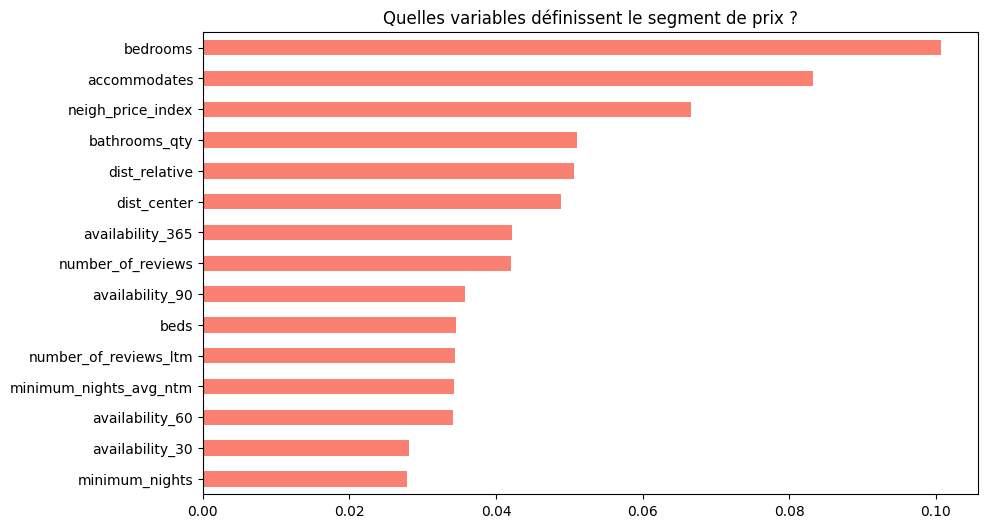


--- 3. VISUALISATION UMAP ---


c:\Users\User\M1ES\ML_ProjectM1\envproject\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


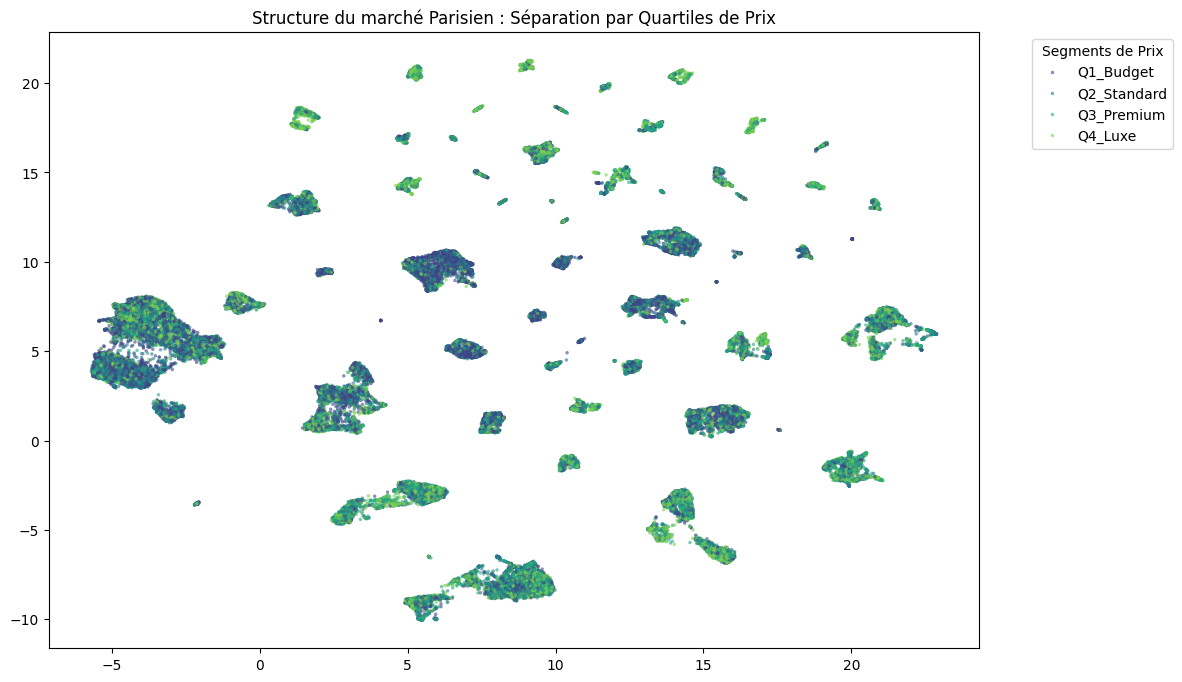

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap

# Imports Scikit-Learn nécessaires
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("--- 1. SEGMENTATION DU MARCHÉ (QUANTILES) ---")

# Création des 4 segments de prix (25% des données chacun)
# Q1: Budget, Q2: Standard, Q3: Premium, Q4: Luxe
df_scaled['price_cat'] = pd.qcut(df_scaled['price_clean'], q=4, 
                                 labels=['Q1_Budget', 'Q2_Standard', 'Q3_Premium', 'Q4_Luxe'])

# Préparation des matrices
X = df_scaled.drop(columns=['price_clean', 'price_cat'])
y = df_scaled['price_cat']

# Découpage avec stratification (pour garder 25% de chaque classe dans le test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Entraînement sur {X_train.shape[0]} lignes.")

print("\n--- 2. ENTRAÎNEMENT DE LA RANDOM FOREST ---")

# Initialisation et entraînement
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

# Prédiction et Score
y_pred = rf_clf.predict(X_test)
print(f"Précision Globale (Accuracy) : {accuracy_score(y_test, y_pred):.2%}")

# Affichage de l'importance des variables
plt.figure(figsize=(10, 6))
importances = pd.Series(rf_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.head(15).plot(kind='barh', color='salmon')
plt.title("Quelles variables définissent le segment de prix ?")
plt.gca().invert_yaxis()
plt.show()

print("\n--- 3. VISUALISATION UMAP ---")

# Calcul de l'UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(X)

# Affichage des clusters colorés par segments de prix
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=embedding[:, 0], 
    y=embedding[:, 1], 
    hue=df_scaled['price_cat'], 
    palette='viridis',
    s=5, 
    alpha=0.6,
    edgecolor=None
)
plt.title("Structure du marché Parisien : Séparation par Quartiles de Prix")
plt.legend(title="Segments de Prix", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()